# Ames Housing Dataset

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy
import math

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate

##Regressors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

##Settings
pd.options.display.max_rows = 30
pd.options.display.max_columns = 40
pd.options.display.float_format = '{:.3f}'.format
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv("train.csv")

In [3]:
test=pd.read_csv("test.csv")

In [4]:
df =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [5]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000,1460.000,1201.000,1460.000,1460.000,1460.000,1460.000,1460.000,1452.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1379.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,70.050,10516.828,6.099,5.575,1971.268,1984.866,103.685,443.640,46.549,567.240,1057.429,1162.627,346.992,5.845,1515.464,0.425,0.058,1.565,0.383,2.866,1.047,6.518,0.613,1978.506,1.767,472.980,94.245,46.660,21.954,3.410,15.061,2.759,43.489,6.322,2007.816,180921.196
std,421.610,42.301,24.285,9981.265,1.383,1.113,30.203,20.645,181.066,456.098,161.319,441.867,438.705,386.588,436.528,48.623,525.480,0.519,0.239,0.551,0.503,0.816,0.220,1.625,0.645,24.690,0.747,213.805,125.339,66.256,61.119,29.317,55.757,40.177,496.123,2.704,1.328,79442.503
min,1.000,20.000,21.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,0.000,0.000,0.000,334.000,0.000,0.000,334.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,1900.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2006.000,34900.000
25%,365.750,20.000,59.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,0.000,223.000,795.750,882.000,0.000,0.000,1129.500,0.000,0.000,1.000,0.000,2.000,1.000,5.000,0.000,1961.000,1.000,334.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,2007.000,129975.000
50%,730.500,50.000,69.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,0.000,477.500,991.500,1087.000,0.000,0.000,1464.000,0.000,0.000,2.000,0.000,3.000,1.000,6.000,1.000,1980.000,2.000,480.000,0.000,25.000,0.000,0.000,0.000,0.000,0.000,6.000,2008.000,163000.000
75%,1095.250,70.000,80.000,11601.500,7.000,6.000,2000.000,2004.000,166.000,712.250,0.000,808.000,1298.250,1391.250,728.000,0.000,1776.750,1.000,0.000,2.000,1.000,3.000,1.000,7.000,1.000,2002.000,2.000,576.000,168.000,68.000,0.000,0.000,0.000,0.000,0.000,8.000,2009.000,214000.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,1474.000,2336.000,6110.000,4692.000,2065.000,572.000,5642.000,3.000,2.000,3.000,2.000,8.000,3.000,14.000,3.000,2010.000,4.000,1418.000,857.000,547.000,552.000,508.000,480.000,738.000,15500.000,12.000,2010.000,755000.000


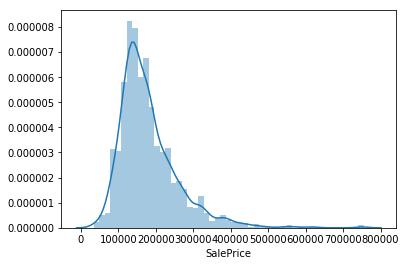

In [6]:
sns.distplot(train["SalePrice"])

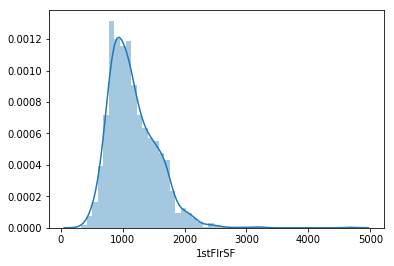

In [7]:
sns.distplot(train["1stFlrSF"])

In [8]:
train.describe(include=["O"])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,...,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,...,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,...,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,...,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,...,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [87]:
train["LSalePrice"]=np.log(train["SalePrice"])

In [88]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,r1stFlrSF,r1stFlrSF_x_Neighborhood,LSalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,...,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,"(769.8, 856.96]","(769.8, 856.96]CollgCr",12.248
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,...,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,"(1205.6, 1292.76]","(1205.6, 1292.76]Veenker",12.109
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,...,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,"(856.96, 944.12]","(856.96, 944.12]CollgCr",12.317
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,...,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,"(944.12, 1031.28]","(944.12, 1031.28]Crawfor",11.849
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,...,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,"(1118.44, 1205.6]","(1118.44, 1205.6]NoRidge",12.429


In [11]:
test.shape

(1459, 80)

In [12]:
train.shape

(1460, 81)

## EDA

### First floor square feet

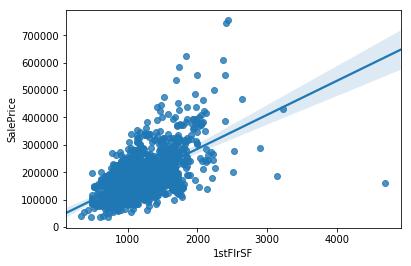

In [77]:
p=sns.regplot(x="1stFlrSF",y="SalePrice",data=train)

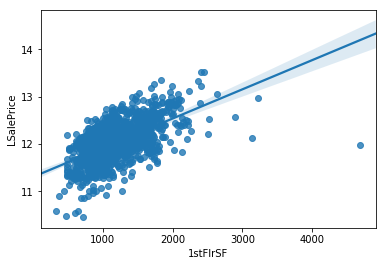

In [89]:
p=sns.regplot(x="1stFlrSF",y="LSalePrice",data=train)

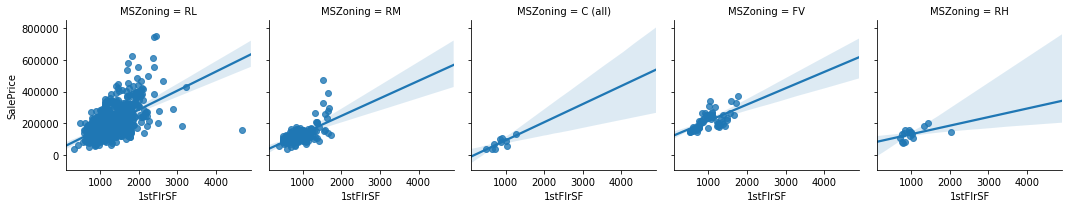

In [14]:
sns.FacetGrid(col="MSZoning",data=train).map(sns.regplot,"1stFlrSF","SalePrice")

(0, 5000)

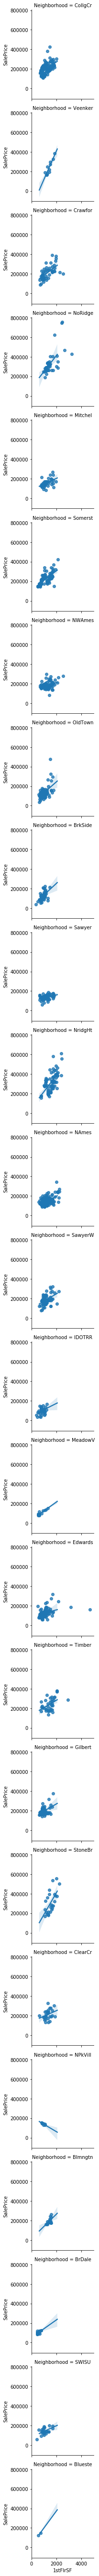

In [15]:
sns.FacetGrid(row="Neighborhood",data=train).map(sns.regplot,"1stFlrSF","SalePrice")
plt.xlim((0,5000))

### Neighborhood

In [16]:
train.groupby("Neighborhood").mean()["SalePrice"]

Neighborhood
Blmngtn   194870.882
Blueste   137500.000
BrDale    104493.750
BrkSide   124834.052
ClearCr   212565.429
CollgCr   197965.773
Crawfor   210624.725
Edwards   128219.700
Gilbert   192854.506
IDOTRR    100123.784
MeadowV    98576.471
Mitchel   156270.122
NAmes     145847.080
NPkVill   142694.444
NWAmes    189050.068
NoRidge   335295.317
NridgHt   316270.623
OldTown   128225.301
SWISU     142591.360
Sawyer    136793.135
SawyerW   186555.797
Somerst   225379.837
StoneBr   310499.000
Timber    242247.447
Veenker   238772.727
Name: SalePrice, dtype: float64

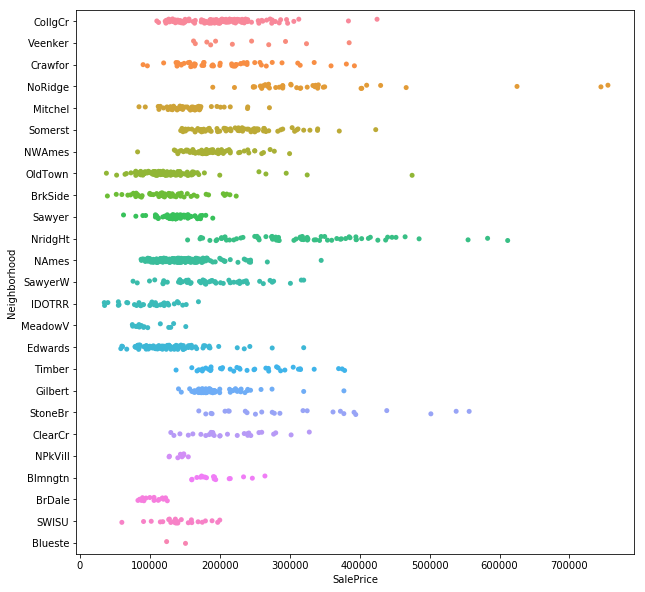

In [17]:
plt.figure(figsize=(10,10))
sns.stripplot(y="Neighborhood",x="SalePrice",data=train,jitter=True)

### Overall condition

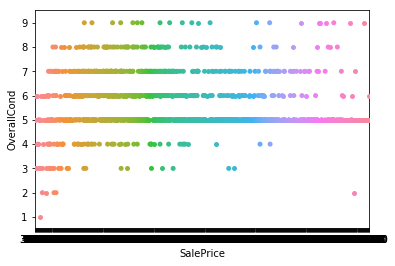

In [19]:
sns.stripplot(y="OverallCond",x="SalePrice",data=train,jitter=True)

### Overall quality

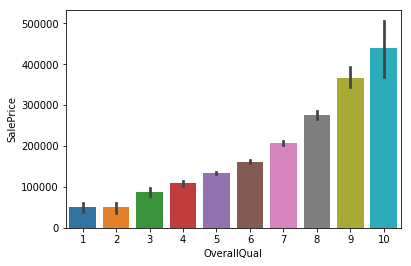

In [20]:
sns.barplot(x="OverallQual",y="SalePrice",data=train)

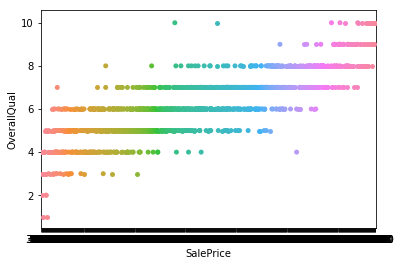

In [21]:
sns.stripplot(y="OverallQual",x="SalePrice",data=train,jitter=True)

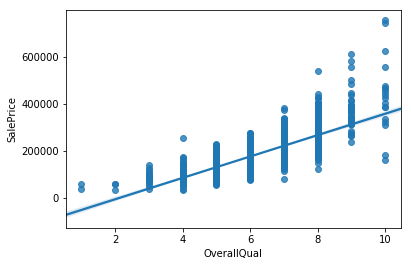

In [22]:
sns.regplot(x="OverallQual",y="SalePrice",data=train)

In [23]:
train[["OverallQual","1stFlrSF"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 2 columns):
OverallQual    1460 non-null int64
1stFlrSF       1460 non-null int64
dtypes: int64(2)
memory usage: 22.9 KB


### Pool Area

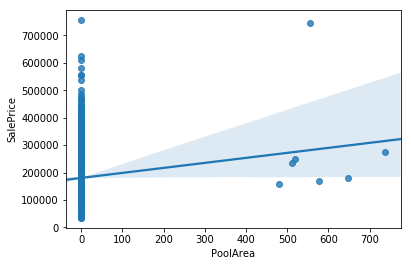

In [24]:
sns.regplot(x="PoolArea",y="SalePrice",data=train)

### Total rooms above grade

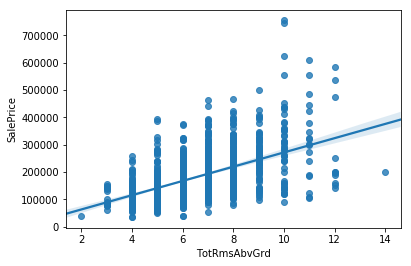

In [25]:
sns.regplot(x="TotRmsAbvGrd",y="SalePrice",data=train)

### Year build

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

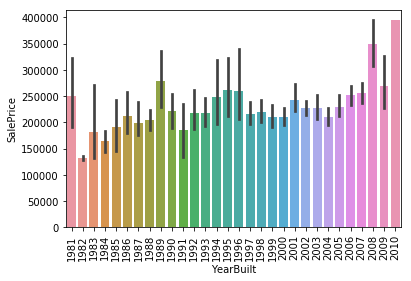

In [26]:
g=sns.barplot(x="YearBuilt",y="SalePrice",data=train[train["YearBuilt"]>1980])
plt.xticks(rotation=90)

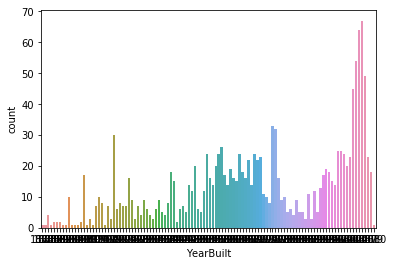

In [27]:
sns.countplot(x="YearBuilt",data=train)

### Remodel year

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
 <a list of 61 Text xticklabel objects>)

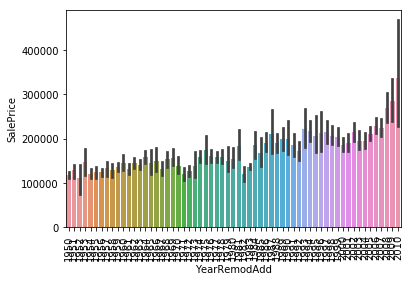

In [57]:
g=sns.barplot(x="YearRemodAdd",y="SalePrice",data=train)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
 <a list of 61 Text xticklabel objects>)

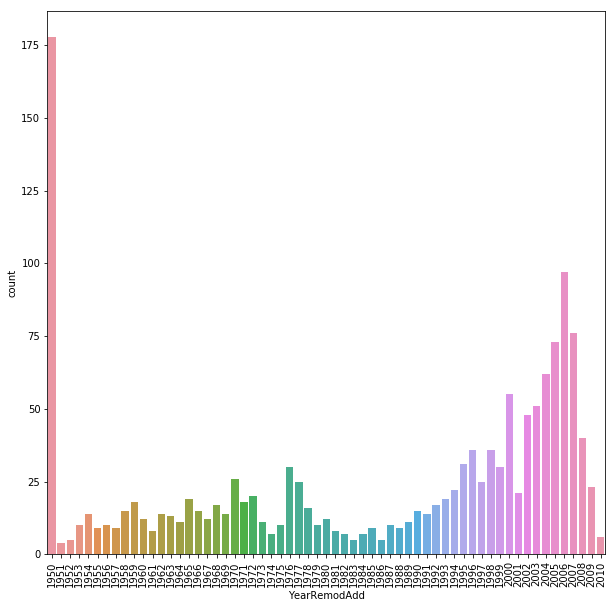

In [58]:
plt.figure(figsize=(10,10))
sns.countplot(x="YearRemodAdd",data=train)
plt.xticks(rotation=90)

### MS Zoning

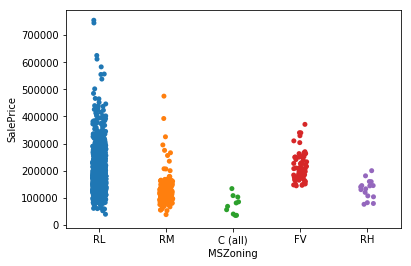

In [30]:
g=sns.stripplot(x="MSZoning",y="SalePrice",jitter=True,data=train)

### MS Subclass

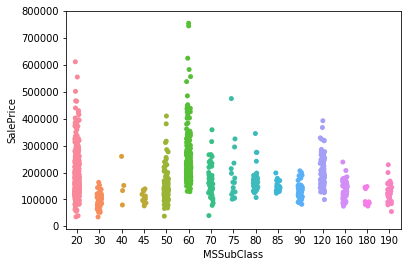

In [31]:
g=sns.stripplot(x="MSSubClass",y="SalePrice",jitter=True,data=train)

### Housestyle

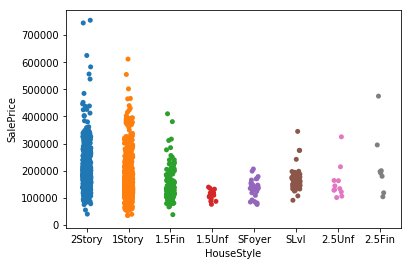

In [32]:
g=sns.stripplot(x="HouseStyle",y="SalePrice",jitter=True,data=train)

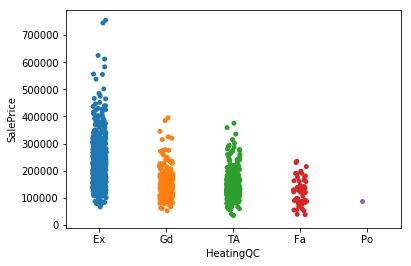

In [33]:
g=sns.stripplot(x="HeatingQC",y="SalePrice",jitter=True,data=train)

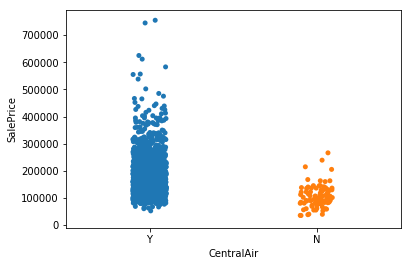

In [34]:
g=sns.stripplot(x="CentralAir",y="SalePrice",jitter=True,data=train)

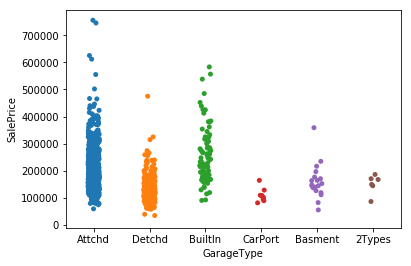

In [35]:
g=sns.stripplot(x="GarageType",y="SalePrice",jitter=True,data=train)

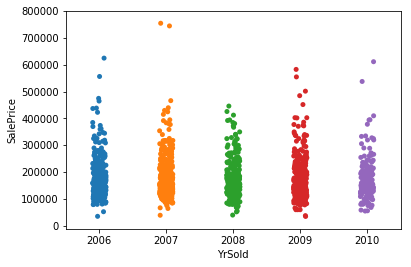

In [36]:
g=sns.stripplot(x="YrSold",y="SalePrice",jitter=True,data=train)

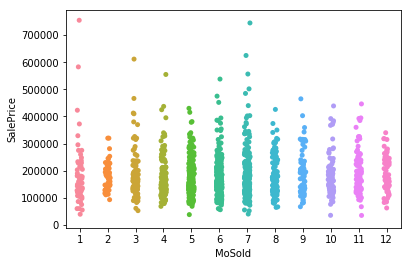

In [37]:
g=sns.stripplot(x="MoSold",y="SalePrice",jitter=True,data=train)

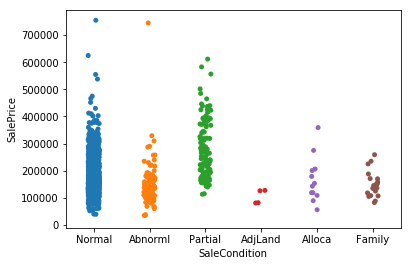

In [38]:
g=sns.stripplot(x="SaleCondition",y="SalePrice",jitter=True,data=train)

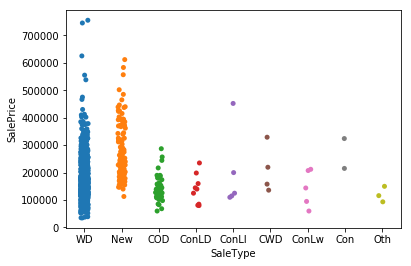

In [39]:
g=sns.stripplot(x="SaleType",y="SalePrice",jitter=True,data=train)

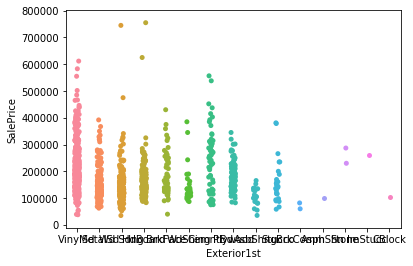

In [40]:
g=sns.stripplot(x="Exterior1st",y="SalePrice",jitter=True,data=train)

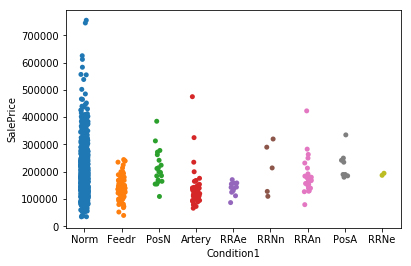

In [41]:
g=sns.stripplot(x="Condition1",y="SalePrice",jitter=True,data=train)

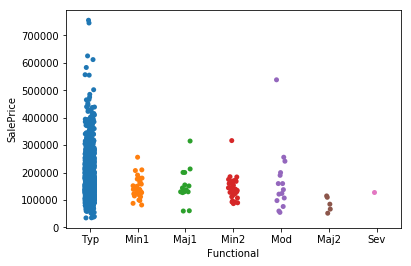

In [42]:
g=sns.stripplot(x="Functional",y="SalePrice",jitter=True,data=train)

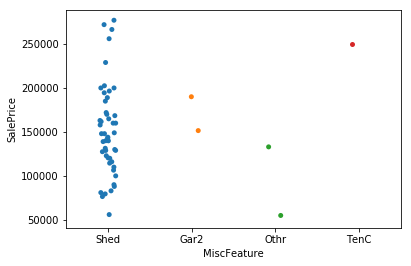

In [43]:
g=sns.stripplot(x="MiscFeature",y="SalePrice",jitter=True,data=train)

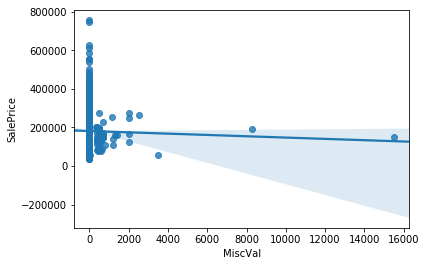

In [44]:
g=sns.regplot(x="MiscVal",y="SalePrice",data=train)

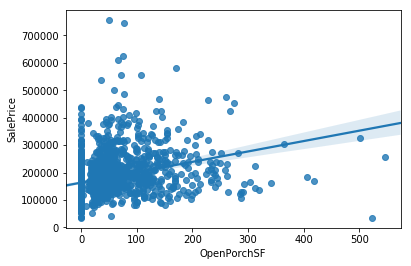

In [45]:
g=sns.regplot(x="OpenPorchSF",y="SalePrice",data=train)

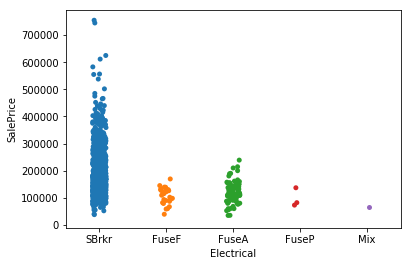

In [46]:
g=sns.stripplot(x="Electrical",y="SalePrice",jitter=True,data=train)

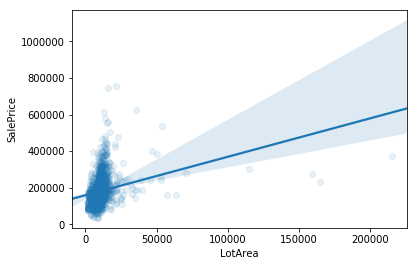

In [85]:
g=sns.regplot(x="LotArea",y="SalePrice",data=train,scatter_kws={'alpha':0.1})

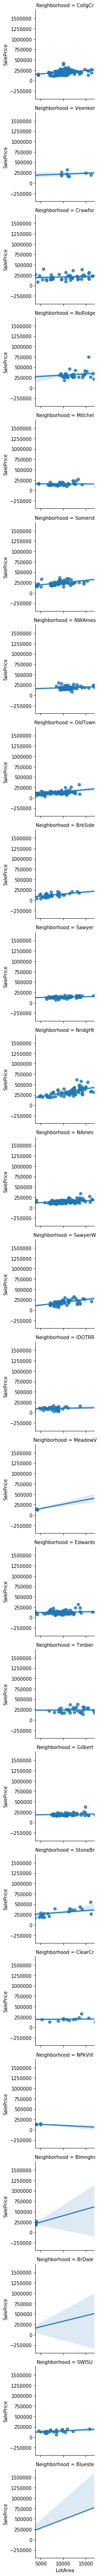

In [83]:
g=sns.FacetGrid(row="Neighborhood",data=train).map(sns.regplot,"LotArea","SalePrice")

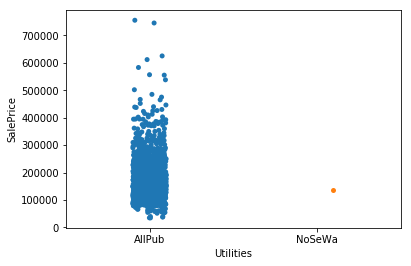

In [48]:
g=sns.stripplot(x="Utilities",y="SalePrice",jitter=True,data=train)

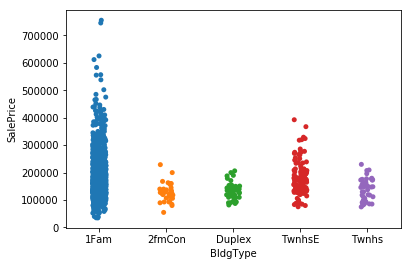

In [49]:
g=sns.stripplot(x="BldgType",y="SalePrice",jitter=True,data=train)

### Feature engineering

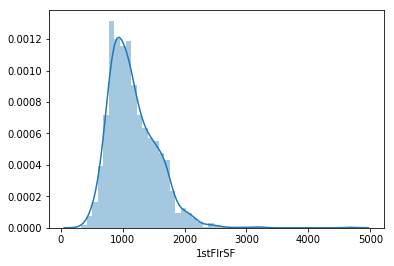

In [50]:
sns.distplot(train["1stFlrSF"])

In [51]:
train["r1stFlrSF"]=pd.cut(x=train["1stFlrSF"],bins=50)

In [52]:
train["r1stFlrSF_x_Neighborhood"]=train["r1stFlrSF"].apply(lambda x: str(x)).values+train["Neighborhood"].values

In [53]:
train["r1stFlrSF_x_Neighborhood"].unique().shape

(306,)

### Model

In [59]:
train_dummies=pd.get_dummies(data=train,columns=["YearBuilt","MSSubClass","Neighborhood","HouseStyle","HeatingQC","CentralAir",
                                                 "SaleType","Functional","r1stFlrSF_x_Neighborhood","BldgType","YearRemodAdd"])
X=train_dummies.drop(columns="SalePrice")
y=train_dummies["SalePrice"].values
X.head()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)
print("X_train shape: %d x %d." % (X_train.shape[0],X_train.shape[1]))
print("X_test shape: %d x %d." % (X_test.shape[0],X_test.shape[1]))

X_train shape: 1095 x 626.
X_test shape: 365 x 626.


In [60]:
def log_mean_squared_error(truth,predictions):
    ltruth=np.log(truth)
    predictions=[i if i>1 else 1 for i in predictions]
    lpredictions=np.log(predictions)
    return np.sqrt(sum((ltruth-lpredictions) ** 2)/len(truth))
lmse_scorer=make_scorer(log_mean_squared_error,greater_is_better=False)

In [61]:
regr=[LinearRegression(),Lasso(alpha=100),Ridge(alpha=10)]

In [68]:
def cross_validation(regr=regr,X_train=X_train,y_train=y_train, features=features,scoring=lmse_scorer,cv=10,
                   table=True):
    names=[]
    mean_test_scores=[]
    test_stds=[]
    mean_train_scores=[]
    train_stds=[]
    coef=[]
    outcomes={}
    for r in regr:
        name=r.__class__.__name__
        names.append(name)
        outcomes[name]=cross_validate(r,X_train[features],y_train,scoring=scoring,cv=cv)
        
        mean_test_scores.append(outcomes[name]["test_score"].mean())
        test_stds.append(outcomes[name]["test_score"].std())
        mean_train_scores.append(outcomes[name]["train_score"].mean())
        train_stds.append(outcomes[name]["train_score"].std())
        
        r.fit(X_train[features],y_train)
        coef.append(r.coef_)
    
    
    regr_results=pd.DataFrame({"Regressor":names,"Mean train score":mean_train_scores,"Train std":train_stds,
                              "Mean test score":mean_test_scores,"test_std":test_stds},index=[1,2,3])
    if table:
        display(regr_results)
    
    results=pd.DataFrame({"Features":features,"LinearRegression":coef[0],"Lasso":coef[1],"Ridge":coef[2]}).sort_values(by="Lasso")
    sns.barplot(x="Features",y="Lasso",data=results[abs(results["Lasso"])>20000])
    plt.xticks(rotation=90)
    plt.title("Strongest weights Lasso")

In [63]:
def add_to_features(list_name_columns):
    outcome=[]
    col_names=X_train.columns.values.tolist()
    for n in list_name_columns:
        temp=[c for c in col_names if c[0:len(n)]==n]
        outcome+=temp
    return outcome


In [66]:
features=add_to_features(["YearBuilt","MSSubClass","Neighborhood","r1stFlrSF_x_Neighborhood","1stFlrSF","Functional",
                          "HeatingQC","CentralAir","HouseStyle","YearRemodAdd"])

,Regressor,Mean train score,Train std,Mean test score,test_std
1,LinearRegression,-0.121,0.012,-3.494,1.459
2,Lasso,-0.160,0.002,-0.187,0.016
3,Ridge,-0.158,0.001,-0.189,0.018


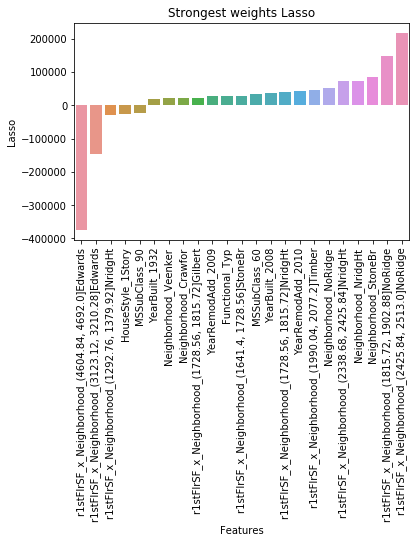

In [69]:
cross_validation(features=features)